## TUTORIAL 02 - Elastic block problem
**_Keywords: POD-Galerkin method, vector problem_**

### 1. Introduction
In this Tutorial we consider a linear elasticity problem in a two-dimensional square domain $\Omega$.

The domain is partioned in nine square subdomains.

Parameters of this problem include Young moduli of each subdomain, as well as lateral traction on the right side of square. In particular:
* the ratio between the Young modulus of the each subdomain $\Omega_{p+1}$, $p=0,\dots,7$ and the top-right subdomain $\Omega_9$ is denoted by $\mu_p$, being

$$
\mu_p \in \left[1, 100\right] \qquad \text{for }p=0,\dots,7.
$$

* the horizontal tractions on each boundary $\Gamma_{p-6}$, $p=8,\dots,10$, being

$$
\mu_p \in \left[-1,1\right] \qquad \text{for } p=8,\dots, 10.
$$

For what concerns the remaining boundaries, the left boundary $\Gamma_6$ is clamped, while the top and bottom boundaries $\Gamma_1 \cup \Gamma_5$ are traction free.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \cdots,\mu_{10})
$$
on the parameter domain
$$
\mathbb{P}=[1,100]^8\times[-1,1]^3.
$$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $\boldsymbol{u}(\boldsymbol{\mu})$ be the displacement in the domain $\Omega$.

In each subdomain $\Omega_{p+1}$, $p=0,\dots,7$, we assume an isotropic linear elastic material, characterized by the following Lamè constants for plane strain
$$\lambda_1(\mu_p) = \frac{\mu_p \nu}{(1+\nu)(1-2\nu)},$$
$$\lambda_2(\mu_p) = \frac{\mu_p}{2(1+\nu)},$$
for $\nu=0.30$, with the following Piola-Kirchhoff tensor

$$
\boldsymbol{\pi}(\boldsymbol{u}; \mu_p) = 
\lambda_1(\mu_p)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\lambda_2(\mu_p)\;\nabla_{S}\boldsymbol{u}
$$
where $\nabla_{S}$ denotes the symmetric part of the gradient.

Similarly, the Piola-Kirchhoff tensor in the top right subdomain $\Omega_9$ is given by $\boldsymbol{\pi}(\boldsymbol{u}; 1)$.

Thus, the Piola-Kirchhoff tensor on the domain $\Omega$ can be obtained as
$$
\boldsymbol{P}(\boldsymbol{u}; \boldsymbol{\mu}) = 
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u}
$$
where
$$
\Lambda_1(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_1(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_1(1) \mathbb{1}_{\Omega_{9}}
$$
$$
\Lambda_2(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_2(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_2(1) \mathbb{1}_{\Omega_{9}}
$$

The strong formulation of the parametrized problem is given by: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $\boldsymbol{u}(\boldsymbol{\mu})$ such that
$$
\begin{cases}
	- \text{div} \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{1},\\
	\boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mu_p \mathbf{n} & \text{on } \Gamma_{p-6}, p=8,\dots, 10,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{5},\\
	\boldsymbol{u}(\boldsymbol{\mu}) = \boldsymbol{0} & \text{on } \Gamma_{6},\\
\end{cases}
$$
<br>

where $\mathbf{n}$ denotes the outer normal to the boundary $\partial\Omega$.

The corresponding weak formulation reads: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{\boldsymbol{v}\in H^1(\Omega; \mathbb{R}^2) : \boldsymbol{v}|_{\Gamma_{6}}=\boldsymbol{0}\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu})=\int_{\Omega}
\left\{
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v}
\right\}  d\boldsymbol{x}
$$,
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v}; \boldsymbol{\mu})= \sum_{p=8}^{10} \mu_p \int_{\Gamma_{p-6}} \boldsymbol{v} \cdot \mathbf{n} \ ds$$.

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

For this problem the affine decomposition is straightforward. Indeed, owing to the definitions of $\Lambda_1(\boldsymbol{\mu})$ and $\Lambda_2(\boldsymbol{\mu})$, we have:
$$
a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu}) = \sum_{p=0}^7 \underbrace{\mu_{\color{red} p}}_{\Theta^{a}_{\color{red} p}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red}{p + 1}}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} p}(\boldsymbol{u}, \boldsymbol{v})} +\\
\underbrace{1}_{\Theta^{a}_{\color{red} 8}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red} 9}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} 8}(\boldsymbol{u}, \boldsymbol{v})}\\
$$
$$
f(\boldsymbol{v}; \boldsymbol{\mu}) = 
\sum_{p=8}^{10} \underbrace{\mu_{\color{red} p}}_{\Theta^{f}_{\color{red}{p-8}}(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{\color{red}{p-6}}} \boldsymbol{v} \cdot \mathbf{n}}_{f_{\color{red}{p-8}}(\boldsymbol{v})}.
$$

We will implement the numerical discretization of the problem in the class
```
class ElasticBlock(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(\boldsymbol{u}, \boldsymbol{v})$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = 1.
            theta_a2 = mu[1]
            theta_a3 = 1.
            theta_a4 = 1.
            theta_a5 = 1.
            theta_a6 = mu[2]
            theta_a7 = 1.
            theta_a8 = mu[3]
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = 1.
            theta_f1 = mu[4]
            theta_f2 = 1.
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1)
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ElasticBlock class

In [5]:
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-6)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

=                ElasticBlock POD-Galerkin offline phase begins                =

###################################### 0 #######################################
truth solve for mu = (55.33253688880515, 71.80374727086952, 60.67357423109274, 54.94343511669279, -0.15269040132219058)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (64.94351719359895, 44.321133915006556, 89.2855270774259, 96.4026132896019, -0.2331169623484446)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (79.3807787701838, 53.360597055537546, 57.2364115482993, 92.63406719097344, -0.8579278836042261)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (9.62580067045253, 3.001621346592246, 83.42936470924586, 78.03751834403519, 0.7400242964936383)
update snapshots matrix

#####################

truth solve for mu = (23.168544117977632, 35.189816388993364, 92.8800480530935, 70.73702579042974, -0.9363221409373843)
update snapshots matrix

###################################### 36 ######################################
truth solve for mu = (17.30472149329336, 62.52636174847659, 58.14563027181259, 24.551389316076353, 0.8684279958495875)
update snapshots matrix

###################################### 37 ######################################
truth solve for mu = (61.7826296406237, 54.02764749947087, 59.40108765910253, 73.28208092216019, -0.3761100090407963)
update snapshots matrix

###################################### 38 ######################################
truth solve for mu = (40.423885159393095, 21.774531148537093, 19.43310758215328, 94.49286660840943, 0.4791015900985751)
update snapshots matrix

###################################### 39 ######################################
truth solve for mu = (49.55542205313914, 23.514048169359, 26.1812916952689, 6.744886872063686, -0.1

update snapshots matrix

###################################### 72 ######################################
truth solve for mu = (19.52595828333363, 90.49441153789546, 54.83678905765531, 46.23423074293081, 0.7640828204597792)
update snapshots matrix

###################################### 73 ######################################
truth solve for mu = (46.40179221509, 72.69259602454278, 40.503506848607095, 90.50039489719481, 0.3800500403824547)
update snapshots matrix

###################################### 74 ######################################
truth solve for mu = (70.26258337080115, 33.44431975415477, 75.92108563095204, 63.97004448926699, -0.5199594532405809)
update snapshots matrix

###################################### 75 ######################################
truth solve for mu = (16.893343426040385, 79.84275597721584, 95.95749370048702, 46.355743898744244, 0.18196833064736984)
update snapshots matrix

###################################### 76 ###################################

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the linear form $f$.

In [ ]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=80)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [ ]:
pinn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [ ]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [ ]:
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W),$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [8]:
input_normalization_prnn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_prnn = Normalization.MinMaxNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=125)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=100000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [9]:
prnn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 66.25920116037278 	Loss(validation) = 51.385466901371274
100 0.5627312498695463 	Loss(validation) = 0.5918471267150772
200 0.1950048738488442 	Loss(validation) = 0.20270710517761792
300 0.10882963419899858 	Loss(validation) = 0.12008962247654864
400 0.08747451678057949 	Loss(validation) = 0.10098397607513099
500 0.07906588198242376 	Loss(validation) = 0.09280848185567175
600 0.07456238134665316 	Loss(validation) = 0.08780697840074145
700 0.07138085190203594 	Loss(validation) = 0.08396952508583624
800 0.06871315885703481 	Loss(validation) = 0.0806693145889594
900 0.0663120330808224 	Loss(validation) = 0.07769279007388416
1000 0.06408168078454976 	Loss(validation) = 0.07493823472181235
1100 0.06196611315679584 	Loss(validation) = 0.07233826488477159
1200 0.059924293197935664 	Loss(validation) = 0.06984317545908761
1300 0.05792611862644162 	Loss(validation) =

12300 0.010313715301923994 	Loss(validation) = 0.022381499120986775
12400 0.01010837412618616 	Loss(validation) = 0.022361462066471237
12500 0.009945535972998609 	Loss(validation) = 0.02254296244983734
12600 0.009751709761533693 	Loss(validation) = 0.022313552826288073
12700 0.009576069046462887 	Loss(validation) = 0.02225991307216829
12800 0.009401594453583625 	Loss(validation) = 0.022198082143280215
12900 0.009236885817194732 	Loss(validation) = 0.022101692199830103
13000 0.009358948896693173 	Loss(validation) = 0.021977492538696856
13100 0.008888312648901355 	Loss(validation) = 0.02195311964551062
13200 0.008713071164347094 	Loss(validation) = 0.02187453073375504
13300 0.008540867669179525 	Loss(validation) = 0.02173070362489653
13400 0.008375646809087913 	Loss(validation) = 0.021628718363514494
13500 0.008237513784533952 	Loss(validation) = 0.021607683068188922
13600 0.008139998324688784 	Loss(validation) = 0.02149507438532864
13700 0.00789629994775416 	Loss(validation) = 0.0213048

24400 0.0017453416412790954 	Loss(validation) = 0.018342824151828124
24500 0.001722265984438788 	Loss(validation) = 0.01826197782085569
24600 0.0017130541763809893 	Loss(validation) = 0.018219125379381897
24700 0.0016912969486207715 	Loss(validation) = 0.01819552805037953
24800 0.0016781424080096674 	Loss(validation) = 0.018133622933914184
24900 0.0016558434821600265 	Loss(validation) = 0.018080281306060448
25000 0.0016404440557900432 	Loss(validation) = 0.018037219693249562
25100 0.0016224658986294035 	Loss(validation) = 0.017971468518790206
25200 0.0016067230102881818 	Loss(validation) = 0.017936930522753608
25300 0.001591797317829257 	Loss(validation) = 0.017896698718167334
25400 0.0015807091626761968 	Loss(validation) = 0.017836170145491614
25500 0.001637134792309959 	Loss(validation) = 0.017835301541267272
25600 0.0015811290079234832 	Loss(validation) = 0.017842629403644495
25700 0.0015675998072559407 	Loss(validation) = 0.01768984213371176
25800 0.002345230255258523 	Loss(validat

36400 0.0009088786174295774 	Loss(validation) = 0.015367976042696473
36500 0.0008360433752305184 	Loss(validation) = 0.015272570738724088
36600 0.0008157892096355502 	Loss(validation) = 0.015345880356667917
36700 0.0007041797269385343 	Loss(validation) = 0.015154669325516418
36800 0.0007006365775093983 	Loss(validation) = 0.015135413535195052
36900 0.0006968091434615435 	Loss(validation) = 0.01513923274658232
37000 0.0007018119719086257 	Loss(validation) = 0.015169101232213048
37100 0.0009703646867138645 	Loss(validation) = 0.015349160893163825
37200 0.0007548303942565285 	Loss(validation) = 0.015209238344316478
37300 0.0007458579300810391 	Loss(validation) = 0.015225183065210974
37400 0.000719634848384505 	Loss(validation) = 0.015087417182462884
37500 0.0006826703754317606 	Loss(validation) = 0.015118278283150686
37600 0.0008257106182730647 	Loss(validation) = 0.015147342819381508
37700 0.0006711932457344993 	Loss(validation) = 0.015021770489922329
37800 0.0006886306313838488 	Loss(va

48300 0.0004086885076994949 	Loss(validation) = 0.01269124616429047
48400 0.0004010534723920286 	Loss(validation) = 0.012639892315392158
48500 0.0005172373600956292 	Loss(validation) = 0.012758143429120279
48600 0.0007766365421144662 	Loss(validation) = 0.012759910239953853
48700 0.0004081045367982999 	Loss(validation) = 0.012523280393411747
48800 0.0003952915532251832 	Loss(validation) = 0.012537124507960712
48900 0.00039890401251297574 	Loss(validation) = 0.01247522237413691
49000 0.0004943402169505605 	Loss(validation) = 0.01267450674093101
49100 0.00042937378360044813 	Loss(validation) = 0.012405847139979425
49200 0.0004825601211695548 	Loss(validation) = 0.012416483258637267
49300 0.0005065791670124426 	Loss(validation) = 0.01239200438946742
49400 0.0006566389856807206 	Loss(validation) = 0.013011957410640419
49500 0.0006806030733870305 	Loss(validation) = 0.012364968890964351
49600 0.0006770747482969418 	Loss(validation) = 0.013023415343612035
49700 0.00039934576053217896 	Loss(v

60200 0.00029293070478636995 	Loss(validation) = 0.010636168264200717
60300 0.0003101892090687418 	Loss(validation) = 0.010653088415249722
60400 0.0002919079109328644 	Loss(validation) = 0.010573072268611532
60500 0.0005388773036939467 	Loss(validation) = 0.010879388223496362
60600 0.0003110030399722551 	Loss(validation) = 0.010598884729952643
60700 0.0004589441972502582 	Loss(validation) = 0.010639768730813588
60800 0.0002849914408643805 	Loss(validation) = 0.01054258100037209
60900 0.00031202314097092203 	Loss(validation) = 0.0105173879029815
61000 0.0002861911020291159 	Loss(validation) = 0.010468387852330927
61100 0.00029942417000733347 	Loss(validation) = 0.010482261753256764
61200 0.0002887785982007642 	Loss(validation) = 0.010445854401280827
61300 0.00032270143687164704 	Loss(validation) = 0.010605571963972656
61400 0.0002822536322676096 	Loss(validation) = 0.010430487638662686
61500 0.00027709849131827354 	Loss(validation) = 0.01045435218773156
61600 0.00027645294858792745 	Los

72100 0.00028838747191992206 	Loss(validation) = 0.009590703565433572
72200 0.0002333373556255743 	Loss(validation) = 0.009525376996420672
72300 0.0002359093318227608 	Loss(validation) = 0.009520561948884555
72400 0.0002393542871254333 	Loss(validation) = 0.00953859817719905
72500 0.000276448618805594 	Loss(validation) = 0.009596525553843308
72600 0.0002223676535973045 	Loss(validation) = 0.00950758724499906
72700 0.00022183653328004786 	Loss(validation) = 0.009501729672268311
72800 0.00023503508958408768 	Loss(validation) = 0.009480918827054725
72900 0.00022155432480077715 	Loss(validation) = 0.009486028017884514
73000 0.0002228525323757044 	Loss(validation) = 0.009465121070415757
73100 0.00022059772056045034 	Loss(validation) = 0.009463502829626016
73200 0.0002207696469469435 	Loss(validation) = 0.009460281081346037
73300 0.0002314917607303555 	Loss(validation) = 0.009470190039275574
73400 0.0002714866096114583 	Loss(validation) = 0.009424640235673912
73500 0.00022740421808671216 	Lo

84000 0.00025049335582149875 	Loss(validation) = 0.008860540203994316
84100 0.00019491137050910745 	Loss(validation) = 0.008725017853550626
84200 0.00023735628147902066 	Loss(validation) = 0.008761241815321431
84300 0.0001935403619099767 	Loss(validation) = 0.008754743367999232
84400 0.0002985612277136703 	Loss(validation) = 0.008887746132955027
84500 0.00018351852286065142 	Loss(validation) = 0.008720264262026189
84600 0.00018630140306009348 	Loss(validation) = 0.008734315440908903
84700 0.00018461159711091738 	Loss(validation) = 0.00870108300158039
84800 0.00019013030520670138 	Loss(validation) = 0.00869709714624087
84900 0.00021461987247228532 	Loss(validation) = 0.008789207490256381
85000 0.0001993198739757558 	Loss(validation) = 0.008711243516216044
85100 0.00018358264774963486 	Loss(validation) = 0.008694092588142244
85200 0.00021435909043596185 	Loss(validation) = 0.008674721916140797
85300 0.000296625469022337 	Loss(validation) = 0.00873611249742484
85400 0.00018076788648447862

95800 0.0002087256117505234 	Loss(validation) = 0.00825525744305927
95900 0.00016240341834402992 	Loss(validation) = 0.008166106273893609
96000 0.00016110319041317476 	Loss(validation) = 0.008174991974121765
96100 0.00016138387535482912 	Loss(validation) = 0.008167015015796468
96200 0.0002020506344093663 	Loss(validation) = 0.00818545240482197
96300 0.0002572581207758944 	Loss(validation) = 0.008290802655506711
96400 0.0001613213268288548 	Loss(validation) = 0.008147713152445255
96500 0.00016432634523316927 	Loss(validation) = 0.008151615489548996
96600 0.00015665668460778233 	Loss(validation) = 0.008144522133472965
96700 0.00015591552139668043 	Loss(validation) = 0.008143536519596987
96800 0.00015564563825030207 	Loss(validation) = 0.008135022573628619
96900 0.00015470288802778818 	Loss(validation) = 0.008134155868631516
97000 0.0003171640447354444 	Loss(validation) = 0.008211980727250833
97100 0.000250400867261564 	Loss(validation) = 0.008155831658344354
97200 0.00015781311370513263 

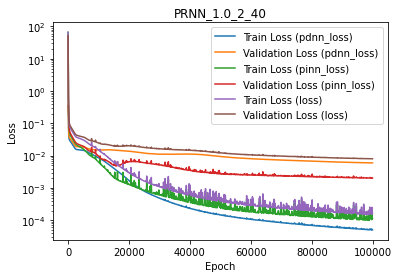

In [10]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [11]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

=               ElasticBlock POD-Galerkin error analysis begins                =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 99 ######################################

N 	gmean(error_u)        	max(error_u)       	gmean(relative_error_u)	max(relative_error_u)
1 	0.19927780949783297   	0.47869278732346776	0.38461767207095693    	0.8710453321160461   
2 	0.07524772982618032   	0.47313078247746265	0.14523246089115863    	0.6862019383236299   
3 	0.06140908645136783   	0.4483717015721346 	0.11852308059009482    	0.6502927776061976   
4 	0.04513381940913807   	0.4474036863031761 	0.08711087600048323    	0.648888823396311    
5 	0.026884519315773812  	0.44672289552368044	0.051888673706502346   	0.6479014432262097   
6 	0.014381017702910644  	0.14035459538319958	0.02775619405313095    	0.203562310827172    
7 	0.009560532649642453  	0.13405449381598214	0.018452379724215325   	0.19442500235524587  
8 	0.006542922603391332  	0.09997194694242247	0.0126282181974917     	0.144993617643437    
9 	0.005773951784727203  	0.09991633012540968	0.011144060142410754   	0.14491295417986416 

#### 4.6.2 PINN Error Analysis

In [16]:
np.random.seed(0)
reduction_method.initialize_testing_set(100)
test_mu = torch.tensor(reduction_method.testing_set)

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (1.0, -1.0), input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (1.0, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [17]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

#################################### N = 17 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.0018325689742102684	0.0017317348168840406	0.00016086903772963645
mean	0.010410139574475407	0.010383358556485955	0.0007091434982020529
max	0.07016117133035003	0.07014387118524616	0.0021554753882416307


In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (1.0, -1.0), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)

### 4.7. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()

In [ ]:
reduced_problem.set_mu(reduction_method.testing_set[0])
reduced_problem.solve()
solution = reduced_problem._solution
np.array(solution.vector()[:])